In [57]:
import pandas as pd

In [58]:
df = pd.read_csv('dummy_inventory_data.csv')

In [59]:
df

,week_start,ingredient,month,quantity_ordered_past,quantity_used,quantity_expired,stock_remaining_end_week,quantity_to_order_correct
0,2023-01-01,Rice,1,68.05,38.82,0.00,29.22,58.82
1,2023-01-01,Cooking Cream,1,63.18,52.48,0.00,10.70,72.48
2,2023-01-01,Chicken,1,63.37,37.10,0.00,26.27,57.10
3,2023-01-01,Broccoli,1,51.85,51.85,0.00,0.00,71.85
4,2023-01-01,Fish,1,47.29,47.29,0.00,0.00,67.29
...,...,...,...,...,...,...,...,...
1035,2026-12-20,Rice,12,72.00,37.74,0.00,34.26,57.74
1036,2026-12-20,Cooking Cream,12,70.00,42.96,2.32,27.04,60.64
1037,2026-12-20,Chicken,12,58.88,47.93,0.00,25.07,53.80
1038,2026-12-20,Broccoli,12,43.46,66.75,0.00,2.25,61.21


In [60]:
import pandas as pd
import numpy as np


# Convert 'week_start' to datetime
df['week_start'] = pd.to_datetime(df['week_start'])

# Extract additional temporal feature: Week of Year
df['week_of_year'] = df['week_start'].dt.isocalendar().week

# Sort data for proper lag feature creation
df = df.sort_values(['ingredient', 'week_start'])

# Create lag features for 'quantity_used' and 'quantity_expired'
df['lag_1_week_used'] = df.groupby('ingredient')['quantity_used'].shift(1)
df['lag_2_week_used'] = df.groupby('ingredient')['quantity_used'].shift(2)
df['lag_1_week_expired'] = df.groupby('ingredient')['quantity_expired'].shift(1)
df['lag_2_week_expired'] = df.groupby('ingredient')['quantity_expired'].shift(2)

# Fill missing lag values with the mean usage/expired
df['lag_1_week_used'].fillna(df['quantity_used'].mean(), inplace=True)
df['lag_2_week_used'].fillna(df['quantity_used'].mean(), inplace=True)
df['lag_1_week_expired'].fillna(df['quantity_expired'].mean(), inplace=True)
df['lag_2_week_expired'].fillna(df['quantity_expired'].mean(), inplace=True)

# Create rolling statistics: 4-week rolling average and std for 'quantity_used'
df['rolling_avg_4_weeks_used'] = df.groupby('ingredient')['quantity_used'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
df['rolling_std_4_weeks_used'] = df.groupby('ingredient')['quantity_used'].transform(lambda x: x.rolling(window=4, min_periods=1).std().fillna(0))

# One-Hot Encode 'ingredient'
df = pd.get_dummies(df, columns=['ingredient'], drop_first=True)

# Define feature columns and target
feature_cols = [
    'stock_remaining_end_week',
    'month',
    'week_of_year',
    'lag_1_week_used',
    'lag_2_week_used',
    'lag_1_week_expired',
    'lag_2_week_expired',
    'rolling_avg_4_weeks_used',
    'rolling_std_4_weeks_used'
] + [col for col in df.columns if 'ingredient_' in col]

# Define the target variable
target_col = 'quantity_to_order_correct'

# Define features (X) and target (y)
X = df[feature_cols]
y = df[target_col]

# Handle any remaining missing values
X.fillna(0, inplace=True)
y.fillna(y.mean(), inplace=True)

# Display the first few rows after feature engineering
print("\nFeatures (X):")
print(X.head())
print("\nTarget (y):")
print(y.head())



Features (X):
    stock_remaining_end_week  month  week_of_year  lag_1_week_used  \
3                       0.00      1            52        46.401163   
8                      15.48      1             1        51.850000   
13                      9.16      1             2        34.520000   
18                      4.18      1             3        41.840000   
23                      0.00      1             4        44.820000   

    lag_2_week_used  lag_1_week_expired  lag_2_week_expired  \
3         46.401163            1.231452            1.231452   
8         46.401163            0.000000            1.231452   
13        51.850000            0.000000            0.000000   
18        34.520000            0.000000            0.000000   
23        41.840000            0.000000            0.000000   

    rolling_avg_4_weeks_used  rolling_std_4_weeks_used  ingredient_Chicken  \
3                  51.850000                  0.000000               False   
8                  43.185000 

C:\Users\hathu\AppData\Local\Temp\ipykernel_16344\100050087.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [61]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False  # Time series split
)

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=40
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Mean Absolute Error (MAE): 3.32
Root Mean Squared Error (RMSE): 4.63


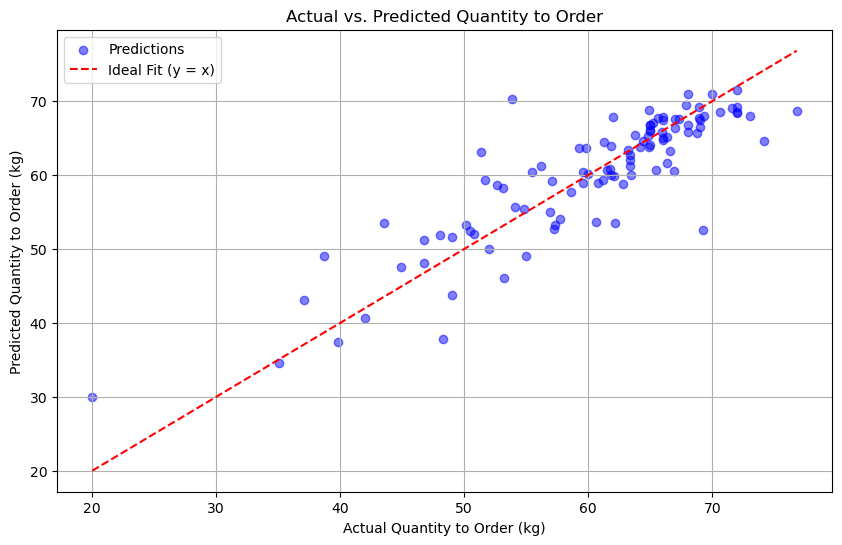

In [62]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')

# Plot the reference line y = x
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit (y = x)')

# Adding labels and title
plt.xlabel('Actual Quantity to Order (kg)')
plt.ylabel('Predicted Quantity to Order (kg)')
plt.title('Actual vs. Predicted Quantity to Order')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 6.14%


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming 'model' is your trained XGBoost model and 'feature_cols' are your feature names

# Extract feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)



Feature Importances:
                     Feature  Importance
0   stock_remaining_end_week    0.311440
3            lag_1_week_used    0.282852
2               week_of_year    0.086370
7   rolling_avg_4_weeks_used    0.055597
6         lag_2_week_expired    0.051536
4            lag_2_week_used    0.043401
1                      month    0.042717
8   rolling_std_4_weeks_used    0.036725
11           ingredient_Fish    0.032886
5         lag_1_week_expired    0.017541
9         ingredient_Chicken    0.016031
12           ingredient_Rice    0.013681
10  ingredient_Cooking Cream    0.009223


In [64]:
# model.save_model('xgboost_model.json')